# Detailed Steps Example

#### This notebook demonstrates how the data cleaning, peak fitting and descriptors generation works step by step, serving as a detailed example of the `ProcessData_PlotDescriptors_Examples.ipynb`.

## Packages and Needed Python Files Preparation
### First we import peackages we need:

In [1]:
# For the purpose of this notebook:
import sys
sys.path.append('../.')

In [2]:
import glob
import itertools
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import peakutils
import scipy
import sqlite3 as sql

from diffcapanalyzer import chachifuncs as ccf

### Then, import the data we want to process:

In [139]:
df = pd.read_csv(os.path.join('../data/ARBIN/CS2_33/CS2_33_8_17_10.csv'))
database = 'example_db.db'
base_filename = 'CS2_33_8_17_10'
datatype = 'ARBIN'

## Processing Data, including Data Cleaning, Peak Fitting and Descriptors Generation

### Data Cleaning
First, we import the raw data of cycle 1

(-10, 10)

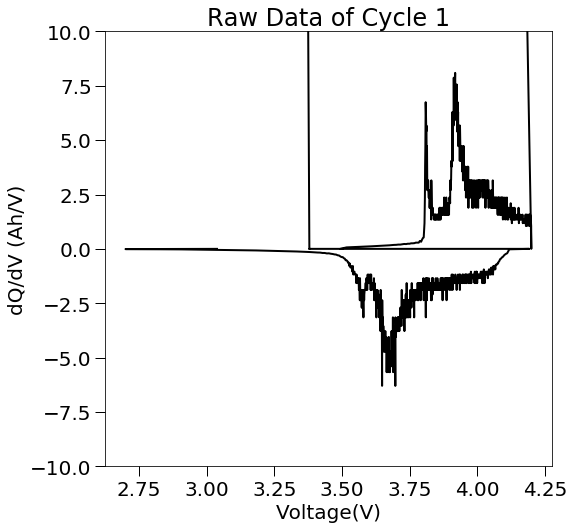

In [144]:
raw_df = ccf.load_sep_cycles(base_filename, database, datatype)
#raw_df_sort = raw_df[1].sort_values('Voltage(V)')

fig1 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

# create the color map based off of the max value in the cycle index column
#colors = matplotlib.cm.Greys(np.linspace(0.3, 1, int(max(raw_df['Cycle_Index']))))

# change the index of raw_df to see other cycles
plt.plot(raw_df[1]['Voltage(V)'], raw_df[1]['dQ/dV'], c = 'black', linewidth = 2, label = 'Raw Cycle Data') 
#plt.plot(raw_df_sort['Voltage(V)'], raw_df_sort['dQ/dV'], c = 'black', linewidth = 2, label = 'Raw Cycle Data') 

plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Raw Data of Cycle 1', fontsize = 24)

# plt.xlim(0, 4)
plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle.png', bbox_inches='tight', dpi = 600)

As we can see in the Raw data, there are several noise and jumps on both ends, So in order to eliminate those noise and jumps, we need to remove those data points which the dV value is about zero.


Therefore, we excute fuction `drop_inf_nan_dqdv` to drop rows where dV=0 (or about 0) in a dataframe that has already had dv calculated, then recalculates dV and calculates dQ/dV.

(-10, 10)

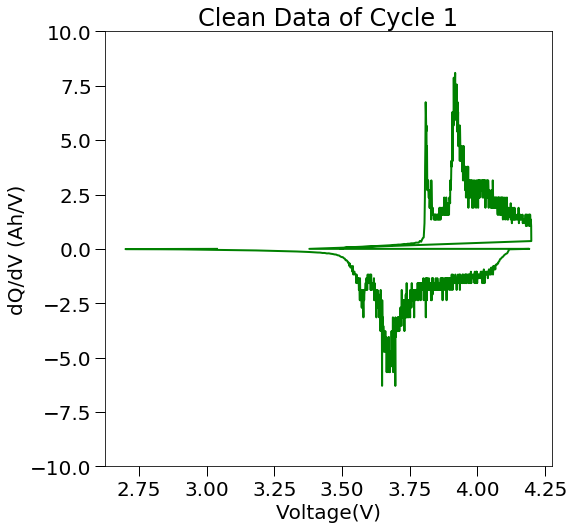

In [145]:
rawdf = ccf.init_columns(raw_df[1], datatype)
rawdf1 = ccf.calc_dq_dqdv(rawdf, datatype)
clean_df = ccf.drop_inf_nan_dqdv(rawdf1, datatype)

fig2 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.3, 1, int(max(clean_df['Cycle_Index']))))

plt.plot(clean_df['Voltage(V)'], clean_df['dQ/dV'], c = 'green', linewidth = 2, label = 'Clean Cycle Data') 

# plt.legend()
# leg = plt.legend(loc = 'upper right', fontsize = 14)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Clean Data of Cycle 1', fontsize = 24)

# plt.xlim(0, 4)
plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle.png', bbox_inches='tight', dpi = 600)

In order to help the computer to recognize peaks more easily later, we need to apply the Savitzky-Golay Filter to  our data to get a nice and smooth curve.

Then, sperate cycles into charge and discharge cycles first, and apply the Savitzky–Golay filter to smooth the data:

(-10, 10)

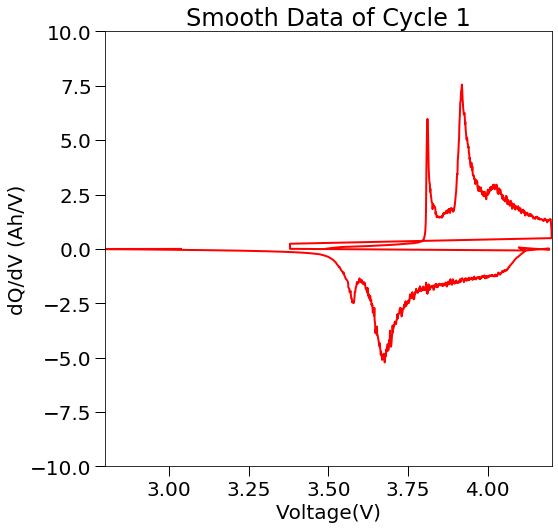

In [146]:
# separating into charge and discharge cycles
charge, discharge = ccf.sep_char_dis(clean_df, datatype)

windowlength = 9
polyorder = 3

# apply Savitzky–Golay filter
if len(discharge) > windowlength:
    smooth_discharge = ccf.my_savgolay(discharge, windowlength, polyorder)
else:
    discharge['Smoothed_dQ/dV'] = discharge['dQ/dV']
    smooth_discharge = discharge
# this if statement is for when the datasets have less datapoints
# than the windowlength given to the sav_golay filter.
# without this if statement, the sav_golay filter throws an error
# when given a dataset with too few points. This way, we simply
# forego the smoothing function.
if len(charge) > windowlength:
    smooth_charge = ccf.my_savgolay(charge, windowlength, polyorder)
else:
    charge['Smoothed_dQ/dV'] = charge['dQ/dV']
    smooth_charge = charge
# same as above, but for charging cycles.

# combine charge and discharge cycle data
smooth_df = charge.append(discharge, ignore_index=True)

fig3 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')
# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.3, 1, int(max(smooth_df['Cycle_Index']))))

plt.plot(smooth_df['Voltage(V)'], smooth_df['Smoothed_dQ/dV'], c = 'red', linewidth = 2, label = 'Smooth Cycle Data') 

#plt.legend()
#leg = plt.legend(loc = 'upper right', fontsize = 14)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Smooth Data of Cycle 1', fontsize = 24)

plt.xlim(2.8, 4.2)
plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle.png', bbox_inches='tight', dpi = 600)

### Peak Fitting
Once we got the smooth data, we then applied an open source package "Peakutils" to locate the peaks for both charge and discharge data.

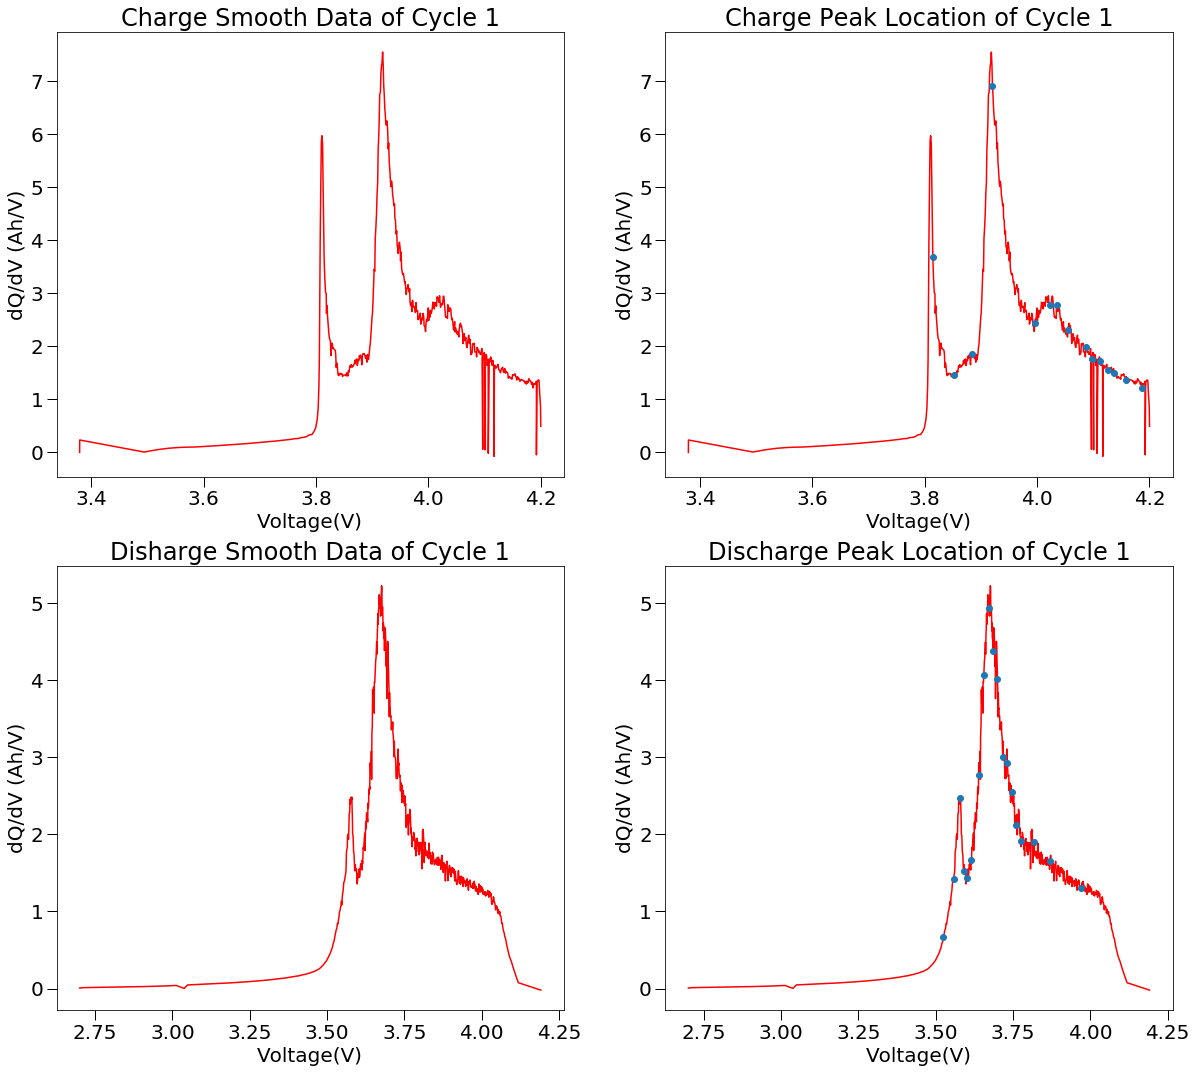

In [147]:
import peakutils
import scipy.signal

# separates charge and discharge cycles using chachifuncs
charge, discharge = ccf.sep_char_dis(smooth_df, datatype)
charge_sort = charge.sort_values('roundedV')
discharge_sort = discharge.sort_values('roundedV')

# takes out x and y-axis
sigx_bot1 = charge_sort['Voltage(V)']
sigy_bot1 = (charge_sort['Smoothed_dQ/dV'])
sigx_bot2 = discharge_sort['Voltage(V)']
sigy_bot2 = -(discharge_sort['Smoothed_dQ/dV'])

# set up a figure
fig4 = plt.figure(figsize = (20,18), facecolor = 'w', edgecolor= 'k')

plt.subplot(2, 2, 1)
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot1, sigy_bot1, 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Charge Smooth Data of Cycle 1', fontsize = 24)

# applies additional level of smoothing to prevent indexing of false peaks
sigy_smooth1 = scipy.signal.savgol_filter(sigy_bot1, 25, 3)

# determines indexes of peaks in the dataset
i1 = peakutils.indexes(sigy_smooth1, thres=.3/max(sigy_bot1), min_dist=9)

plt.subplot(2, 2, 2)
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot1, sigy_bot1, 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Charge Peak Location of Cycle 1', fontsize = 24)
plt.plot(sigx_bot1[i1], sigy_bot1[i1], 'o')

plt.subplot(2, 2, 3)
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot2, sigy_bot2, 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Disharge Smooth Data of Cycle 1', fontsize = 24)

# applies additional level of smoothing to prevent indexing of false peaks
sigy_smooth2 = scipy.signal.savgol_filter(sigy_bot2, 25, 3)

# determines indexes of peaks in the dataset
i2 = peakutils.indexes(sigy_smooth2, thres=.3/max(sigy_bot2), min_dist=9)

plt.subplot(2, 2, 4)
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot2, sigy_bot2, 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Discharge Peak Location of Cycle 1', fontsize = 24)
plt.plot(sigx_bot2[i2], sigy_bot2[i2], 'o')

Following that, we continued to apply another package "lmfit" to generate models that fit those peaks, which generates a mixture of Pseudo-Voigt distributions with a 4th degree polynomial background is fitted to the peak.

In [148]:
from lmfit import models

# creates a polynomial fitting object
modc = models.PolynomialModel(4)
modd = models.PolynomialModel(4)

# sets polynomial parameters based on a
# guess of a polynomial fit to the data with no peaks
parc = modc.guess(sigy_bot1, x=sigx_bot1)
pard = modd.guess(sigy_bot2, x=sigx_bot2)

# iterates over all peak indices
for index in i1:
    
    # generates unique parameter strings based on index of peak
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    # generates a pseudo voigt fitting model
    gaus_loopc = models.PseudoVoigtModel(prefix = comb)
    parc.update(gaus_loopc.make_params())
    
    # uses unique parameter strings to generate parameters with initial guesses
    # in this model, the center of the peak is locked at the peak location determined from PeakUtils
    parc[comb+cent].set(sigx_bot1[index], vary = False)
    
    # the other initial parameters were found by trial and error
    parc[comb+sig].set(0.01)
    parc[comb+amp].set(.05, min = 0)
    parc[comb+fract].set(.5)
    
    # adds each pseudo voigt model to the polynomial model
    modc = modc + gaus_loopc
    
for index in i2:
    
    # generates unique parameter strings based on index of peak
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    # generates a pseudo voigt fitting model
    gaus_loopd = models.PseudoVoigtModel(prefix = comb)
    pard.update(gaus_loopd.make_params())
    
    # uses unique parameter strings to generate parameters with initial guesses
    # in this model, the center of the peak is locked at the peak location determined from PeakUtils
    pard[comb+cent].set(sigx_bot2[index], vary = False)
    
    # the other initial parameters were found by trial and error
    pard[comb+sig].set(0.01)
    pard[comb+amp].set(.05, min = 0)
    pard[comb+fract].set(.5)
    
    # adds each pseudo voigt model to the polynomial model
    modd = modd + gaus_loopd

Final fit generation: The following code uses the "mod" and "par" objects found above to determine the final fit to the battery cycle. The execution of this model is performed below:

In [149]:
# evaluates fit using the default scipy.leastsquare method
modelc = modc.fit(sigy_bot1, parc, x=sigx_bot1)
modeld = modd.fit(sigy_bot2, pard, x=sigx_bot2)

# generates a fit report containing fit parameters as well as error values
# print(model.fit_report(min_correl=0.5))

# plots data
fig5 = plt.figure(figsize = (14,8), facecolor = 'w', edgecolor= 'k')

plt.subplot(1, 2, 1)
plt.plot(sigx_bot1, sigy_bot1, 'r')
plt.plot(sigx_bot1, modelc.init_fit, 'k--')
plt.plot(sigx_bot1, modelc.best_fit, 'b-')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.rcParams.update({'font.size':20})
plt.title('Charge Peak Fitting of Cycle 1', fontsize = 24)
plt.legend(['Data', 'Initial Model', 'Fitted Model'], loc=2, fontsize=10)

plt.subplot(1, 2, 2)
plt.plot(sigx_bot2, sigy_bot2, 'r')
plt.plot(sigx_bot2, modeld.init_fit, 'k--')
plt.plot(sigx_bot2, modeld.best_fit, 'b-')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.rcParams.update({'font.size':20})
plt.title('Discharge Peak Fitting of Cycle 1', fontsize = 24)
plt.legend(['Data', 'Initial Model', 'Fitted Model'], loc=2, fontsize=10)

KeyboardInterrupt: 